# Juego de Detección y Captura de Gestos de Manos

## Descripción

Este repositorio contiene el código fuente para un proyecto que implementa un sistema de detección y captura de gestos de manos en tiempo real. El sistema utiliza la biblioteca MediaPipe para la detección de manos y OpenCV para el procesamiento de imágenes.

## Funcionalidades

- Detección de manos en tiempo real.
- Captura de imágenes de las manos detectadas.
- Almacenamiento de las imágenes capturadas en carpetas según el gesto detectado.
- Visualización de información sobre los gestos detectados en la interfaz gráfica.

## Instalación de librerias 

`pip install -r requirements.txt`

## Grafico de una seña para cada clase

Creación de un gráfico con una imagen representativa de cada clase.

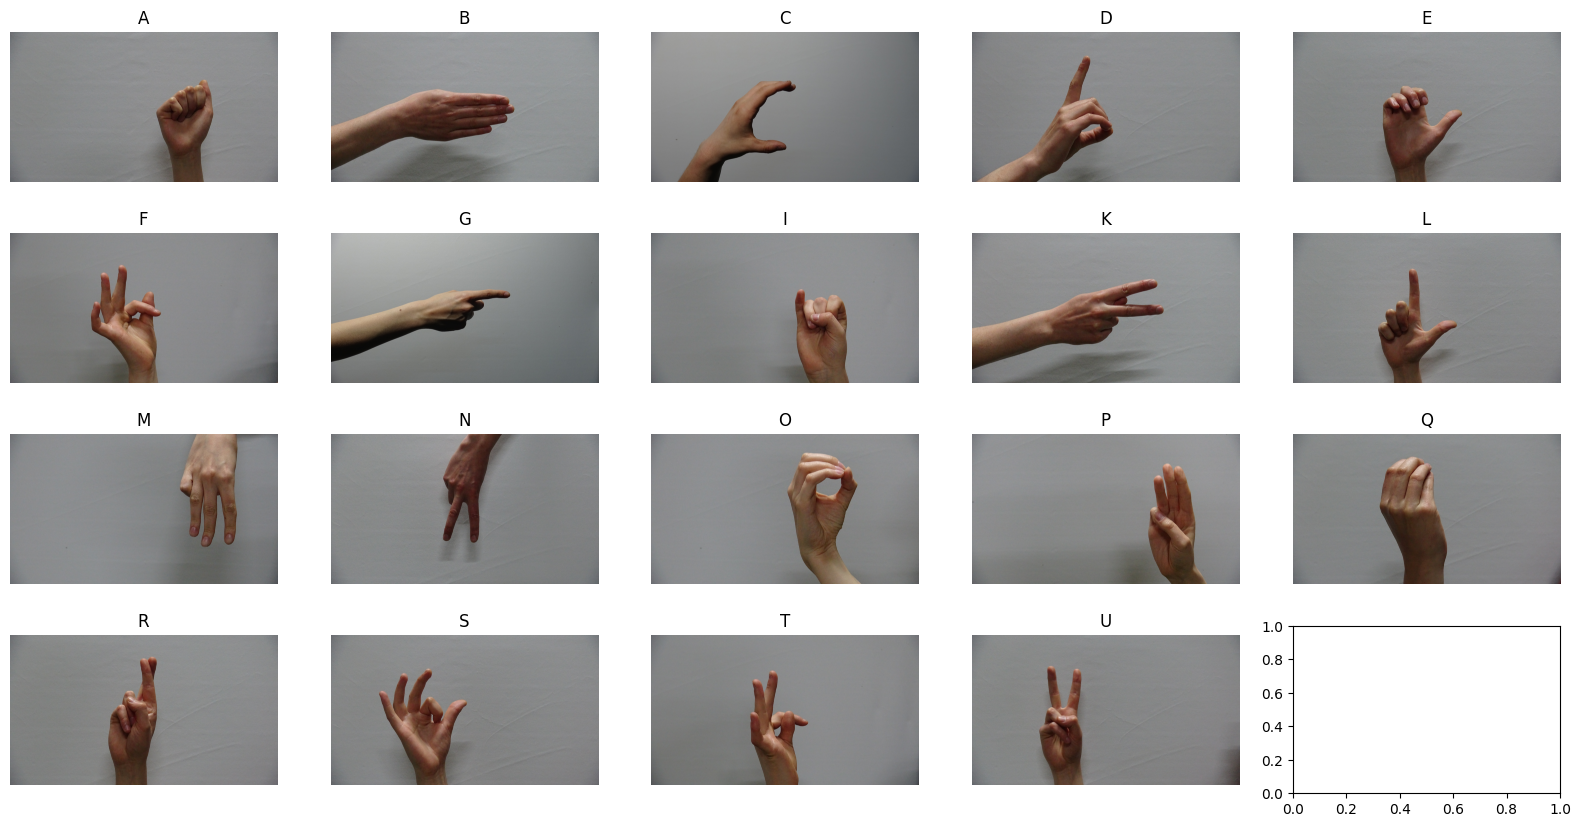

In [1]:
import matplotlib.pyplot as plt
import os
import random
from matplotlib import image as mpimg
import json

# Carga el diccionario que mapea nombres de clases a índices desde un archivo JSON
class_indices = json.load(open('class_indices.json'))

classes_path = './classes/'  # Ruta de la carpeta que contiene las subcarpetas de clases

# Obtiene la lista de nombres de clases a partir de las claves del diccionario
classes = list(class_indices.keys())

# Crea una figura y un conjunto de ejes con un tamaño específico para mostrar las imágenes
fig, axes = plt.subplots(4, 5, figsize=(20, 10))

# Itera sobre las primeras 19 clases o menos (si hay menos de 19 clases en total)
for i in range(min(len(classes), 19)):
    class_name = classes[i]  # Obtiene el nombre de la clase en el índice actual
    img_name = random.choice(os.listdir(f'{classes_path}{class_name}'))  # Elige aleatoriamente el nombre de una imagen en la carpeta correspondiente a la clase
    img_path = f'{classes_path}{class_name}/{img_name}'  # Construye la ruta de la imagen seleccionada
    
    img = mpimg.imread(img_path)  # Lee la imagen desde el archivo en la ruta especificada
    
    # Muestra la imagen en los ejes correspondientes y establece el título como el nombre de la clase
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(class_name)
    axes[i // 5, i % 5].axis('off')  # Desactiva los ejes
    
# Muestra la figura que contiene las imágenes
plt.show()


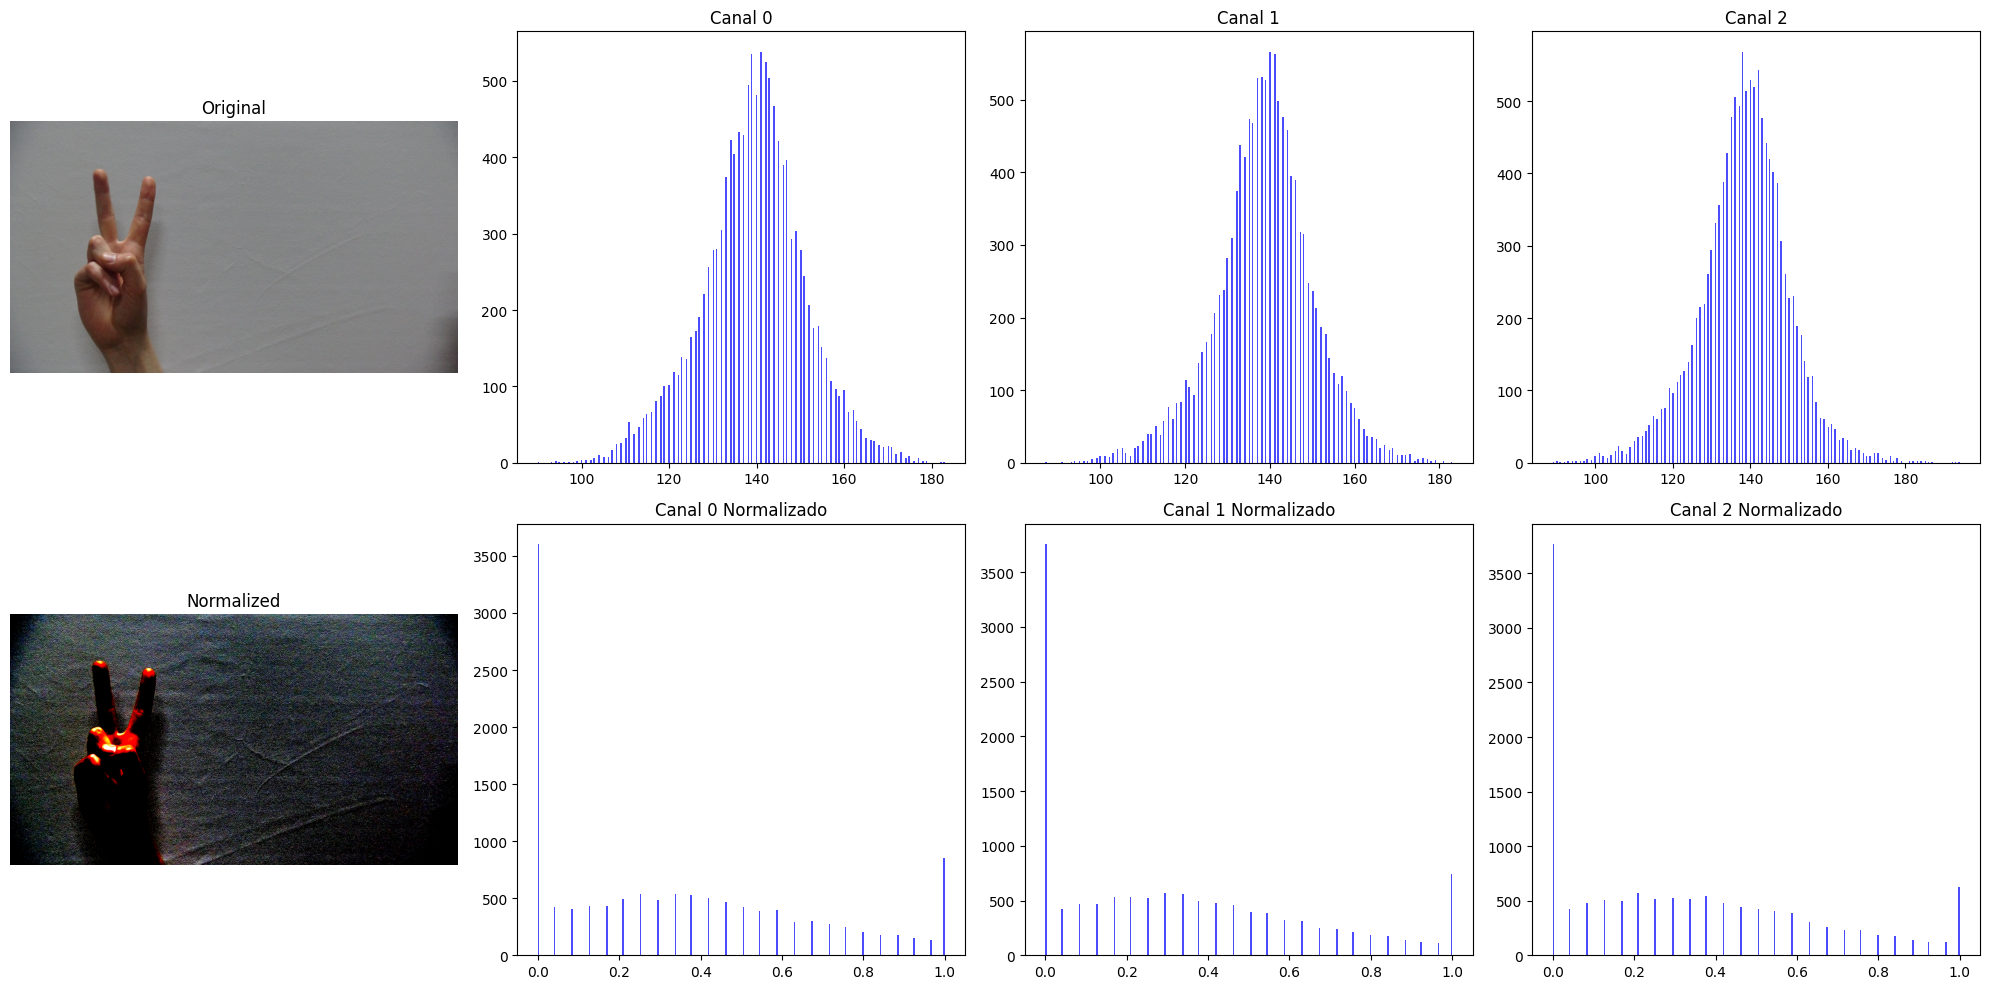

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Definición de función para graficar histograma
def plot_histogram(ax, channel, title):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)
    ax.set_title(title)

# img = cv2.imread("./classes/E/DSC02287.JPG") # Cargar la imagen
imf = random.choice(os.listdir(f'{classes_path}E'))  # Elige aleatoriamente el nombre de una imagen en la carpeta correspondiente a la clase
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convertir de RGB a BGR

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Crear una figura y un conjunto de ejes

axes[0, 0].imshow(img) 
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Graficar histogramas para cada canal de color
for i in range(3):
    channel = img[i]
    plot_histogram(axes[0, i + 1], channel, f'Canal {i}')

img_normalized = np.zeros_like(img, dtype=np.float32) # Crear una matriz para almacenar la imagen normalizada

channel = img / 255  # Normanizar la imagen dividiendo cada píxel por 255
channel_med = np.median(channel)  # Calcular la mediana
channel_std = np.std(channel)  # Calcular la desviación estándar

if channel_std > 0:
    img_normalized= (channel - channel_med) / channel_std # Normalizar la imagen utilizando la fórmula (x - media) / desviación estándar
else:
    img_normalized = 0 # Si la desviación estándar es cero, establecer todos los valores en cero

img_normalized = np.clip(img_normalized, 0, 1) # Asegurarse de que los valores estén en el rango [0, 1]

axes[1, 0].imshow(img_normalized)
axes[1, 0].set_title('Normalized')
axes[1, 0].axis('off')

# Graficar histogramas para cada canal de color normalizado
for i in range(3):
    channel_normalized = img_normalized[i]
    plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

plt.tight_layout()
plt.show()


## Normalizacion en tiempo real

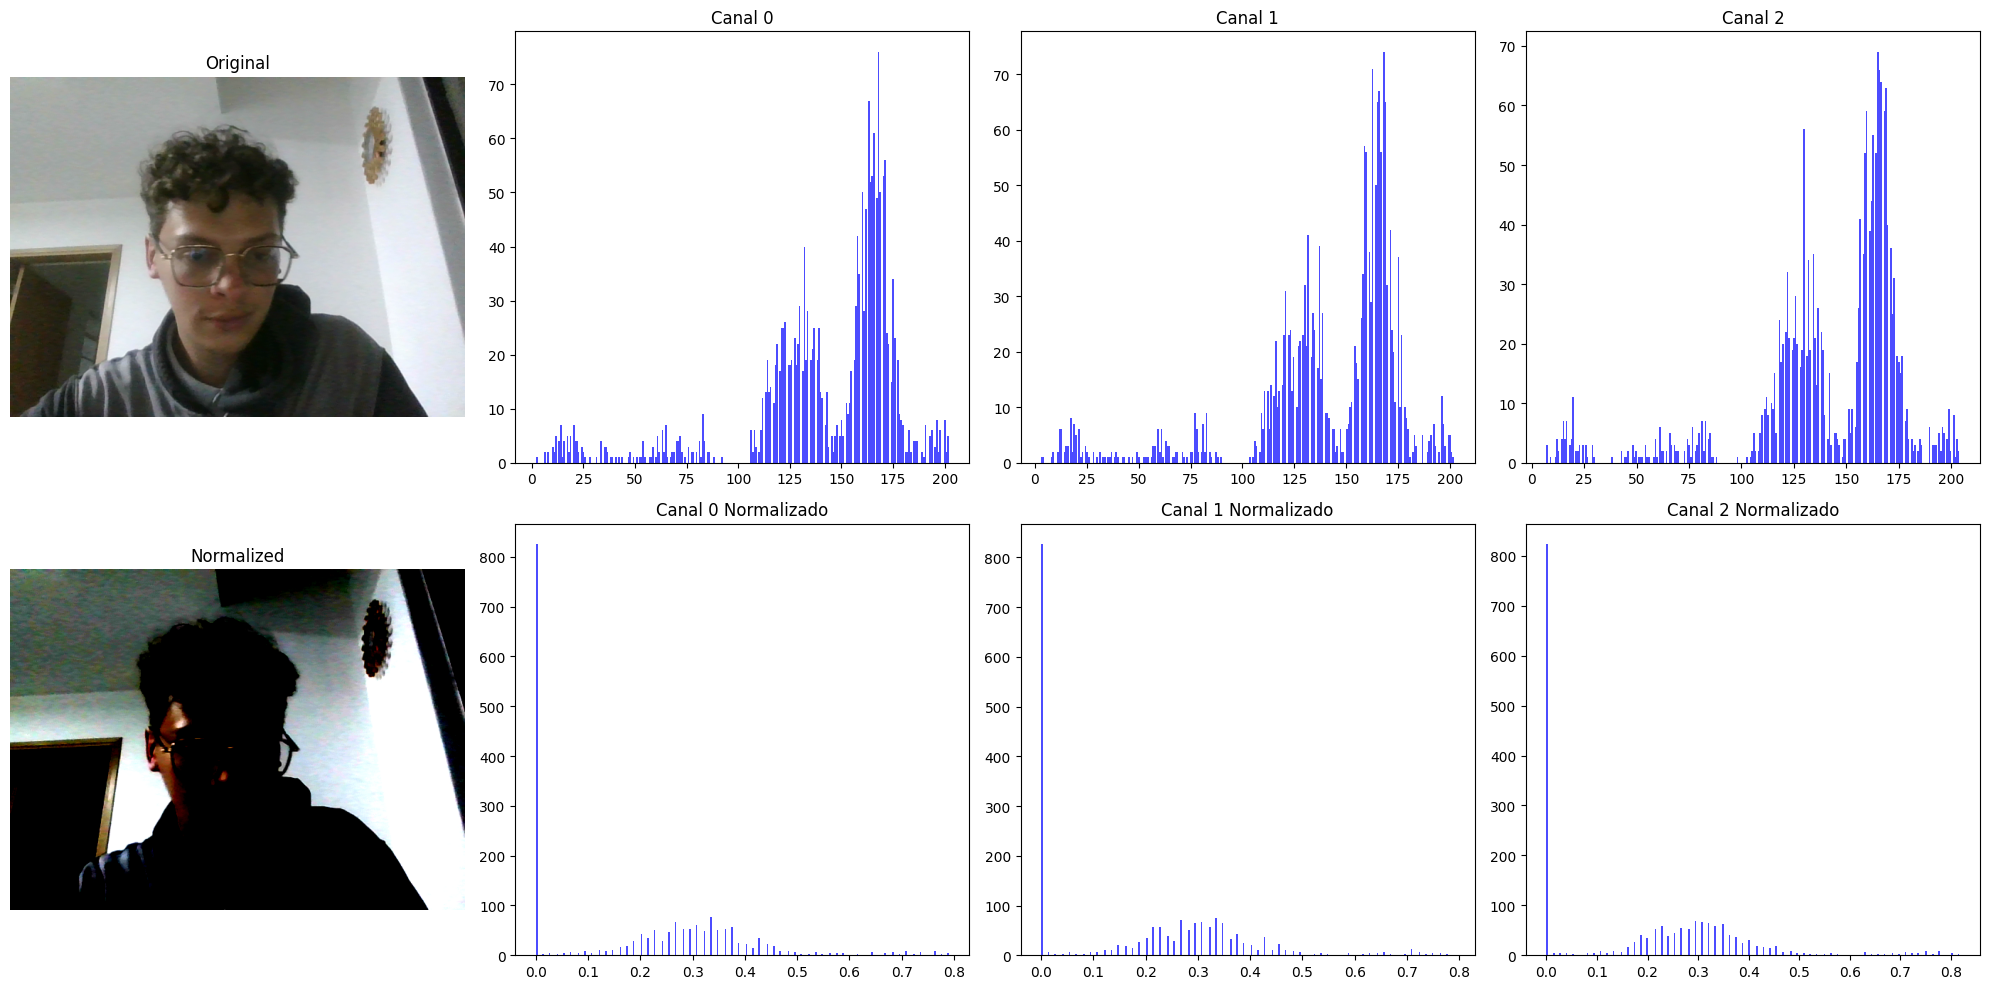

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Función para trazar histogramas
def plot_histogram(ax, channel, title):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)  # Trazar histograma usando matplotlib
    ax.set_title(title)  # Establecer el título del histograma

# Función para calcular histograma
def calculate_histogram(channel):
    hist = cv2.calcHist([channel], [0], None, [256], [0, 256])  # Calcular el histograma utilizando OpenCV
    return hist

# Captura de video desde la cámara
cap = cv2.VideoCapture(0)

while True:  # Bucle principal para procesar cada fotograma
    _, frame = cap.read()  # Leer un fotograma de la cámara

    if frame is None:  # Si no se obtiene ningún fotograma, salir del bucle
        break

    frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convertir el fotograma de RGB a BGR

    # Normalizar la imagen
    frame_normalized = np.zeros_like(frame_, dtype=np.float32)

    channel = frame_ / 255  # Escalar los valores de los canales a [0, 1]
    channel_med = np.median(channel)  # Calcular el valor mediano
    channel_std = np.std(channel)  # Calcular la desviación estándar

    # Aplicar la fórmula de normalización
    if channel_std > 0:
        frame_normalized = (channel - channel_med) / channel_std
    else:
        frame_normalized = channel

    # Recortar los valores para que estén en el rango válido [0, 1] para la visualización
    frame_normalized = np.clip(frame_normalized, 0, 1)
    
    cv2.imshow("Frame", np.concatenate((channel, frame_normalized), axis=1))  # Mostrar el fotograma original y el convertido

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Esperar hasta que se presione 'q' para realizar más acciones
        
        # Crear una figura para mostrar los resultados
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))

        # Mostrar el fotograma original en la primera subfigura
        axes[0, 0].imshow(frame_)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')

        # Trazar histogramas antes de la normalización para cada canal de color
        for i in range(3):
            channel = frame_[i]
            plot_histogram(axes[0, i + 1], channel, f'Canal {i}')

        # Mostrar el fotograma normalizado en la segunda subfigura
        axes[1, 0].imshow(frame_normalized)
        axes[1, 0].set_title('Normalized')
        axes[1, 0].axis('off')

        # Trazar histogramas después de la normalización para cada canal de color
        for i in range(3):
            channel_normalized = frame_normalized[i]
            plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

        # Ajustar el diseño de la figura y mostrarla
        plt.tight_layout()
        plt.show()
        break  # Salir del bucle al finalizar la visualización y el procesamiento

# Liberar los recursos (cerrar la captura de video y las ventanas abiertas)
cap.release()
cv2.destroyAllWindows()

## Definición de los estimadores de pose

In [4]:
import cv2
import mediapipe as mp
import numpy as np
        
# Función para dibujar puntos y líneas de las manos
def draw_hand_landmarks(frame, landmarks, COLOR):
    height, width, _ = frame.shape
    x_min, y_min, x_max, y_max = width, height, 0, 0
    
    # Dibujar puntos y líneas de las manos
    for i, point in enumerate(landmarks.landmark):
        x, y = int(point.x * width), int(point.y * height)
        color = (0, 255, 0) if i % 4 == 0 else (0, 0, 255)
        cv2.circle(frame, (x, y), int(height * 0.01), color, -1)
        # Actualizar los límites del cuadrado
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x)
        y_max = max(y_max, y)
    
    connections = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]
    for connection in connections:
        cv2.line(frame, (int(landmarks.landmark[connection[0]].x * width), int(landmarks.landmark[connection[0]].y * height)),
                 (int(landmarks.landmark[connection[1]].x * width), int(landmarks.landmark[connection[1]].y * height)), COLOR, 2)
    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 255), 2)

# Inicializar los modelos de MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Constantes para colores
BLUE = (255, 0, 0)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error al abrir la cámara")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error al leer el frame")
            break

        # Convertir el frame de BGR a RGB
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detección de las manos
        hands_results = hands.process(img)

        # Crear una imagen negra del mismo tamaño que el frame
        black_frame = np.zeros_like(frame)

        # Dibujar círculos y líneas para las manos en la imagen negra
        if hands_results.multi_hand_landmarks:
            for landmarks in hands_results.multi_hand_landmarks:
                draw_hand_landmarks(black_frame, landmarks, BLUE)

        cv2.imshow('Pose Detection', black_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

2024-04-04 20:08:18.620604: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 20:08:18.658411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 20:08:19.530464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1712279300.877545   61550 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712279300.883371   61811 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) Xe G

## Crear Dataset de poses redimensionadas


In [5]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import time
import os
os.environ['GLOG_minloglevel'] = '3' 
import warnings
warnings.filterwarnings("ignore")

In [28]:

# Función para dibujar los puntos de referencia de la mano y las conexiones entre ellos
def draw_hand_landmarks(frame, landmarks, COLOR, margin=15):
    height, width = frame.shape  # Obtiene las dimensiones del frame
    x_min, y_min, x_max, y_max = width, height, 0, 0  # Inicializa los límites del rectángulo que rodea la mano

    for i, point in enumerate(landmarks.landmark):
        x, y = int(point.x * width), int(point.y * height)  # Calcula las coordenadas del punto en píxeles
        color = (0, 255, 0) if i % 4 == 0 else (0, 0, 255)  # Alterna el color entre verde y rojo para cada punto
        cv2.circle(frame, (x, y), int(height * 0.01), color, -1)  # Dibuja un círculo en el punto

        # Agregar número de punto sobre cada punto
        # cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Actualiza las coordenadas mínimas y máximas para dibujar un rectángulo alrededor de la mano
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x)
        y_max = max(y_max, y)

    # Definir conexiones solo para el contorno de la mano y los dedos
    connections = [[1, 2], [2, 3], [3, 4],  # Dedo pulgar
                   [5, 6], [6, 7], [7, 8],  # Dedo índice
                   [9, 10], [10, 11], [11, 12],  # Dedo medio
                   [13, 14], [14, 15], [15, 16],  # Dedo anular
                   [17, 18], [18, 19], [19, 20],  # Dedo meñique
                   [0, 1],[0, 17],[1, 5], [5, 9], [9, 13], [13, 17]]  # Conexiones de la palma de la mano

    # Dibujar las conexiones entre los puntos de referencia de la mano
    for connection in connections:
        cv2.line(frame, (int(landmarks.landmark[connection[0]].x * width), int(landmarks.landmark[connection[0]].y * height)),
                         (int(landmarks.landmark[connection[1]].x * width), int(landmarks.landmark[connection[1]].y * height)), COLOR, 2)

    # Retorna el frame con los puntos de referencia de la mano y los límites del rectángulo que rodea la mano
        # Calculate the width and height of the hand rectangle
    hand_width = x_max - x_min
    hand_height = y_max - y_min

    # Calculate the side length of the square bounding box
    square_side = max(hand_width, hand_height)

    # Calculate the coordinates of the square bounding box
    x_min_square = x_min + hand_width // 2 - square_side // 2
    x_max_square = x_min_square + square_side
    y_min_square = y_min + hand_height // 2 - square_side // 2
    y_max_square = y_min_square + square_side

    # Make sure the square bounding box is within the frame
    x_min_square = max(0, x_min_square)
    y_min_square = max(0, y_min_square)
    x_max_square = min(width, x_max_square)
    y_max_square = min(height, y_max_square)

    # Return the square bounding box instead of the hand rectangle
    return frame, (x_min_square-margin, y_min_square-margin, x_max_square+margin, y_max_square+margin)
    # return frame, (x_min-margin, y_min-margin, x_max+margin, y_max+margin)


In [5]:



# Función para capturar frames de la cámara y guardarlos en carpetas correspondientes a cada letra
def capture_frames(period, folder, num_frames):
    # Crea la carpeta principal si no existe
    if not os.path.exists(folder):
        os.makedirs(folder)

    letters = ["A", "B", "C", "D", "E", "F", "G", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U"]

    # Crea subcarpetas para cada letra del alfabeto
    for letter in letters:
        letter_folder = os.path.join(folder, letter)
        if not os.path.exists(letter_folder):
            os.makedirs(letter_folder)

    cap = cv2.VideoCapture(0)  # Inicializa la cámara
    count = 0  # Contador para capturar frames
    letter_idx = 0  # Índice de la letra actual
    frames_taken = 0  # Contador para el número de frames tomados por letra

    while True:
        ret, frame = cap.read()  # Lee un frame de la cámara

        # Si no se pudo leer el frame, termina el ciclo
        if not ret:
            print("Error al leer el frame")
            break

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convierte el frame de BGR a RGB

        hands_results = hands.process(img)  # Procesa el frame con el modelo de manos
        black_frame = np.zeros_like(frame)  # Crea una imagen negra del mismo tamaño que el frame

        # Dibuja puntos y líneas para las manos en la imagen negra
        if hands_results.multi_hand_landmarks:
            for landmarks in hands_results.multi_hand_landmarks:
                drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks, (0, 0, 255))  # Dibuja puntos y líneas para las manos
                # Guarda el frame en la carpeta correspondiente
                if count % period == 0 and frames_taken < num_frames:
                    letter = letters[letter_idx]  # Obtiene la letra actual
                    letter_folder = os.path.join(folder, letter)  # Obtiene la carpeta correspondiente a la letra
                    try: 
                        frame_resized = cv2.resize(drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]], (512, 512))  # Redimensiona el frame
                        #cv2.imwrite(os.path.join(letter_folder, f"{time.time()}.jpg"), cv2.cvtColor(drawn_frame, cv2.COLOR_BGR2GRAY))  # Guarda el frame en la carpeta
                        frames_taken += 1  # Incrementa el contador de frames tomados por letra
                        count = 0  # Reinicia el contador
                    except: 
                        pass
                if frames_taken >= num_frames:
                    frames_taken = 0  # Reinicia el contador de frames tomados por letra
                    letter_idx = (letter_idx + 1) % len(letters)  # Cambia a la siguiente letra
                count += 1

        cv2.putText(frame, f'Letra: {letters[letter_idx]}, {letter_idx}', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)  # Muestra la letra actual
        cv2.putText(frame, f'Capturas: {frames_taken}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)  # Muestra el número de frames tomados
        cv2.imshow('Pose Detection', frame)  # Muestra el frame con las manos detectadas
        
        # Si se presiona la tecla 'q', termina el ciclo
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            break

    cap.release() # Liberar la cámara
    cv2.destroyAllWindows() # Cerrar todas las ventanas
    hands.close() # Cerrar el modelo de manos

# mp_hands = mp.solutions.hands # Importar el modelo de manos de MediaPipe
# hands = mp_hands.Hands() # Inicializar el modelo de manos

# capture_frames(15, "classes_poses_cut", 1) # Capturar frames cada 15 frames y guardar 100 frames por letra en la carpeta "classes_poses_cut"



I0000 00:00:1712791206.463916   16067 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712791206.466950   16431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import mediapipe as mp
import skimage.feature as skif

def preprocess_image(frame):
    # Noise reduction
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    
    # Intensity normalization
    frame = cv2.normalize(frame, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Color correction (convert to grayscale)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Convert the image to uint8
    frame = cv2.convertScaleAbs(frame, alpha=(255.0))
    
    return frame

def segment_hand(frame):
    # Thresholding
    _, frame = cv2.threshold(frame, 127, 255, cv2.THRESH_BINARY)
    
    # Morphological operations
    kernel = np.ones((5,5),np.uint8)
    frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, kernel)
    frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, kernel)
    
    return frame

def extract_features(frame):
    # Local descriptors (HOG)
    hog = skif.hog(frame, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys')
    
    # Texture features (GLCM)
    glcm = skif.greycomatrix(frame, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True, symmetric=True)
    contrast = skif.greycoprops(glcm, 'contrast')
    dissimilarity = skif.greycoprops(glcm, 'dissimilarity')
    homogeneity = skif.greycoprops(glcm, 'homogeneity')
    energy = skif.greycoprops(glcm, 'energy')
    correlation = skif.greycoprops(glcm, 'correlation')
    
    # Combine features into a single array
    features = np.hstack([hog, contrast.flatten(), dissimilarity.flatten(), homogeneity.flatten(), energy.flatten(), correlation.flatten()])
    
    return features

def process_images(directory, new_directory='classes_1'):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()

    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file
            new_subdir = new_directory + subdir[len(directory):]
            try: 
                os.makedirs(new_subdir, exist_ok=True)
            except Exception as e:
                print(f"Error creating directory {new_subdir}: {e}")

            if filepath.endswith(".JPG") or filepath.endswith(".jpg"):
                frame = cv2.imread(filepath)
                
                # Preprocessing
                frame = preprocess_image(frame)
                
                # Hand segmentation
                frame = segment_hand(frame)
                
                img = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
                hands_results = hands.process(img)
                plt.imshow(frame)

                if hands_results.multi_hand_landmarks:
                    for landmarks in hands_results.multi_hand_landmarks:
                        drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks, (0, 0, 255), 75)
                        try: 
                            frame_resized = cv2.resize(drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]], (512, 512))
                            
                            # Feature extraction
                            features = extract_features(frame_resized)
                            
                            plt.imshow(frame_resized) 
                            print(features)
                            plt.show()  
                            # cv2.imwrite(os.path.join(new_subdir, file), frame_resized)


                        except Exception as e: 
                            print(f"Error processing file {filepath}: {e}")
                
    hands.close()

process_images('classes')

2024-04-28 19:15:52.082468: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 19:15:52.119488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 19:15:53.222294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1714349754.513214   24337 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714349754.514909   25791 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) Xe G

KeyboardInterrupt: 